## Data Science - LGMVIP

### Task - 2: Stock Market Prediction and Forecasting using Stacked LSTM

### Importing the Necessary Libraries

In [19]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import LSTM
%matplotlib inline

In [20]:
import tensorflow as tf
print(tf.__version__)


2.12.0


### Loading the Dataset

In [21]:
df = pd.read_csv("https://raw.githubusercontent.com/ebisajr/ds-link/main/smpfds.csv")


In [22]:
#Display the first five rows of the dataset
df.head() 

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


In [23]:
df.tail()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
2030,2010-07-27,117.6,119.50,112.00,118.80,118.65,586100,694.98
2031,2010-07-26,120.1,121.00,117.10,117.10,117.60,658440,780.01
2032,2010-07-23,121.8,121.95,120.25,120.35,120.65,281312,340.31
2033,2010-07-22,120.3,122.00,120.25,120.75,120.90,293312,355.17
2034,2010-07-21,122.1,123.00,121.05,121.10,121.55,658666,803.56


There are no missing values in the dataset. So, we can proceed.

In [24]:
df['Date'] = pd.to_datetime(df['Date'])

In [25]:
df = df.sort_values('Date')
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
2034,2010-07-21,122.1,123.00,121.05,121.10,121.55,658666,803.56
2033,2010-07-22,120.3,122.00,120.25,120.75,120.90,293312,355.17
2032,2010-07-23,121.8,121.95,120.25,120.35,120.65,281312,340.31
2031,2010-07-26,120.1,121.00,117.10,117.10,117.60,658440,780.01
2030,2010-07-27,117.6,119.50,112.00,118.80,118.65,586100,694.98


In [26]:
df.reset_index(inplace=True)

## Information about the dataset

In [27]:
df.shape

(2035, 9)

In [28]:
df.columns

Index(['index', 'Date', 'Open', 'High', 'Low', 'Last', 'Close',
       'Total Trade Quantity', 'Turnover (Lacs)'],
      dtype='object')

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2035 entries, 0 to 2034
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   index                 2035 non-null   int64         
 1   Date                  2035 non-null   datetime64[ns]
 2   Open                  2035 non-null   float64       
 3   High                  2035 non-null   float64       
 4   Low                   2035 non-null   float64       
 5   Last                  2035 non-null   float64       
 6   Close                 2035 non-null   float64       
 7   Total Trade Quantity  2035 non-null   int64         
 8   Turnover (Lacs)       2035 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(2)
memory usage: 143.2 KB


In [30]:
df.size

18315

In [31]:
df.dtypes

index                            int64
Date                    datetime64[ns]
Open                           float64
High                           float64
Low                            float64
Last                           float64
Close                          float64
Total Trade Quantity             int64
Turnover (Lacs)                float64
dtype: object

## Data Cleaning and Preprocessing

In [32]:
# Check for null values
df.isnull().sum()

index                   0
Date                    0
Open                    0
High                    0
Low                     0
Last                    0
Close                   0
Total Trade Quantity    0
Turnover (Lacs)         0
dtype: int64

This shows that there are no missing values in dataset

In [33]:
# Checking for the duplicate values
duplicates = df.duplicated()
duplicates.value_counts()

False    2035
dtype: int64

This shows that there are no duplicate values

## Statistics of the Dataset

In [34]:
df.describe()

,index,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
count,2035.000000,2035.000000,2035.000000,2035.000000,2035.000000,2035.00000,2.035000e+03,2035.000000
mean,1017.000000,149.713735,151.992826,147.293931,149.474251,149.45027,2.335681e+06,3899.980565
std,587.598219,48.664509,49.413109,47.931958,48.732570,48.71204,2.091778e+06,4570.767877
min,0.000000,81.100000,82.800000,80.000000,81.000000,80.95000,3.961000e+04,37.040000
25%,508.500000,120.025000,122.100000,118.300000,120.075000,120.05000,1.146444e+06,1427.460000
50%,1017.000000,141.500000,143.400000,139.600000,141.100000,141.25000,1.783456e+06,2512.030000
75%,1525.500000,157.175000,159.400000,155.150000,156.925000,156.90000,2.813594e+06,4539.015000
max,2034.000000,327.700000,328.750000,321.650000,325.950000,325.75000,2.919102e+07,55755.080000


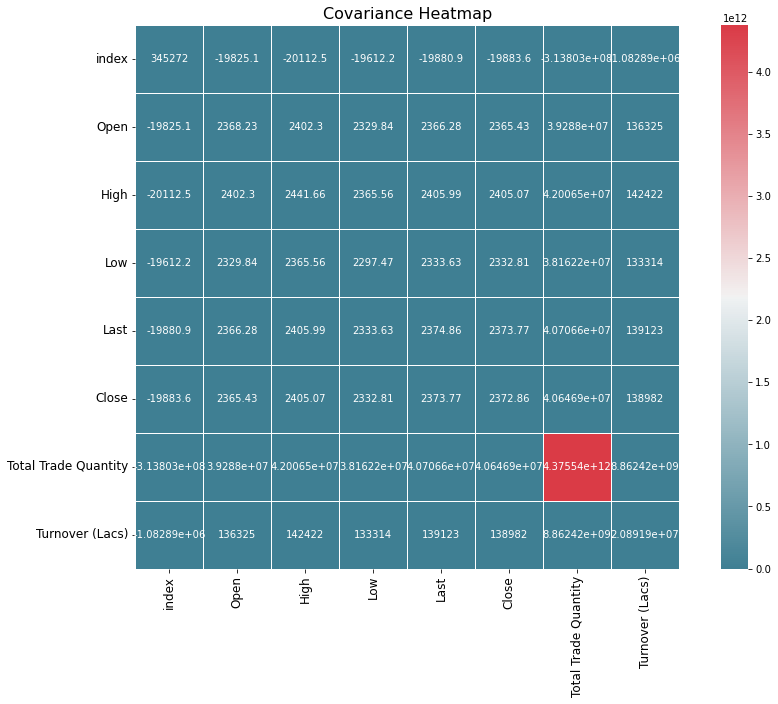

In [35]:
plt.figure(figsize=(15, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)  # Define a custom color map
sns.heatmap(df.cov(), annot=True, fmt='g', cmap=cmap, linewidths=0.5, square=True)
plt.title('Covariance Heatmap', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [36]:
df_open= df.reset_index()['Open']
print(df_open)

0       122.10
1       120.30
2       121.80
3       120.10
4       117.60
         ...  
2030    233.55
2031    233.30
2032    240.00
2033    234.55
2034    234.05
Name: Open, Length: 2035, dtype: float64


## Visualize Data

#### Plot the graphs for Open, Close, High, Low, & Last price

Text(0.5, 1.0, 'Open')

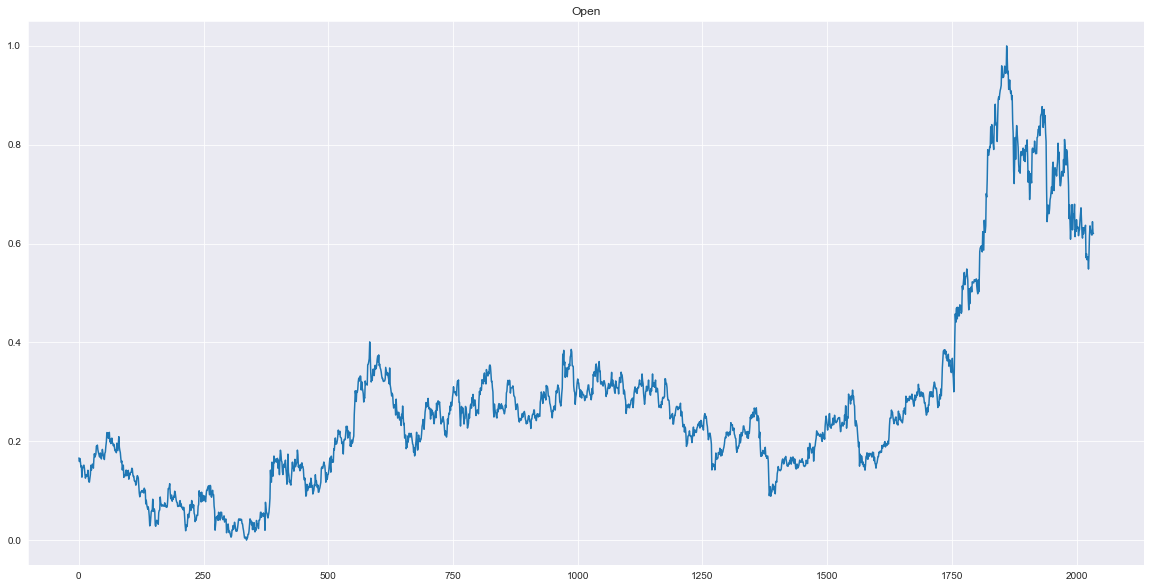

In [134]:
plt.subplots(figsize = (20,10))
plt.plot(df_open ,)
plt.title("Open")

##### OR

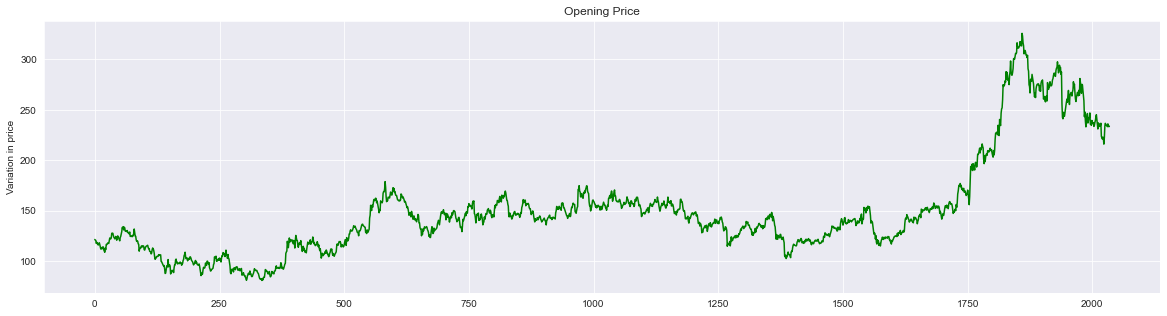

In [38]:
sns.set_style('darkgrid')
plt.figure(figsize = (20,5))
plt.plot(df.Close, color = 'g')
plt.ylabel('Variation in price')
plt.title("Opening Price")
plt.show()

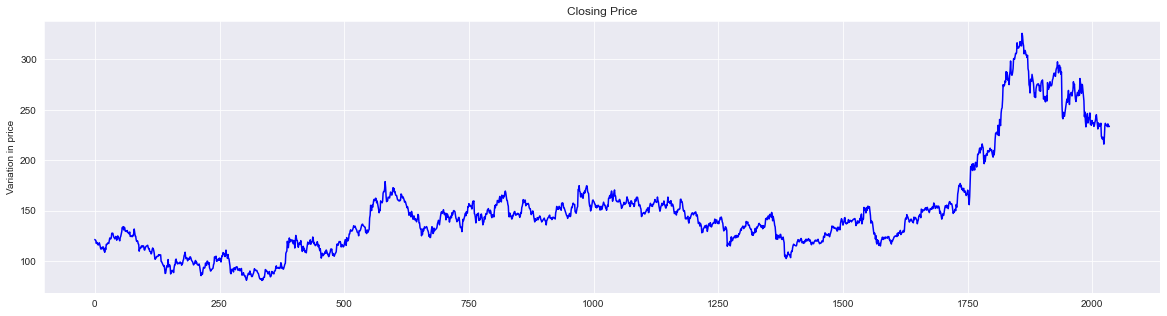

In [39]:
sns.set_style('darkgrid')
plt.figure(figsize = (20,5))
plt.plot(df.Close, color = 'b')
plt.ylabel('Variation in price')
plt.title("Closing Price")
plt.show()

In [40]:
df_close = df['Close']
df_close

0       121.55
1       120.90
2       120.65
3       117.60
4       118.65
         ...  
2030    233.30
2031    236.10
2032    234.25
2033    233.25
2034    233.75
Name: Close, Length: 2035, dtype: float64

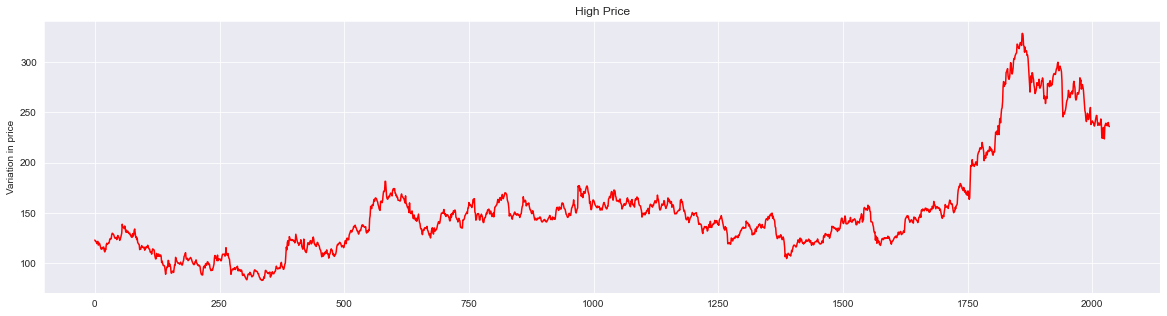

In [41]:
sns.set_style('darkgrid')
plt.figure(figsize = (20,5))
plt.plot(df.High, color = 'r')
plt.ylabel('Variation in price')
plt.title("High Price")
plt.show()
     

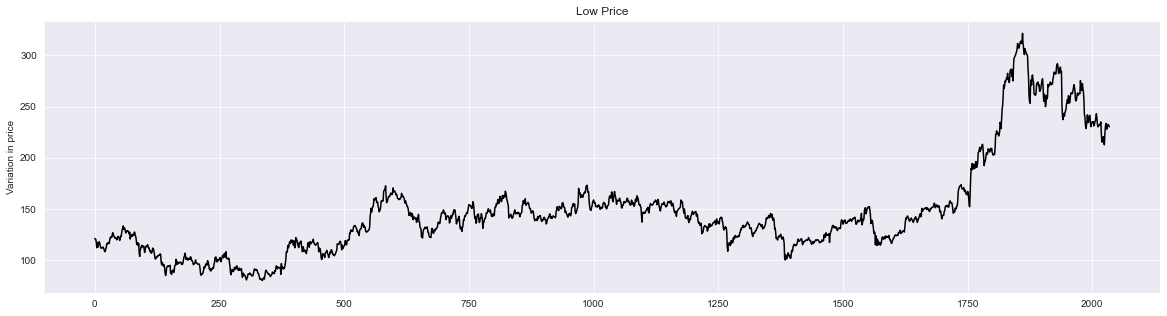

In [42]:
sns.set_style('darkgrid')
plt.figure(figsize = (20,5))
plt.plot(df.Low, color = 'black')
plt.ylabel('Variation in price')
plt.title("Low Price")
plt.show()
     

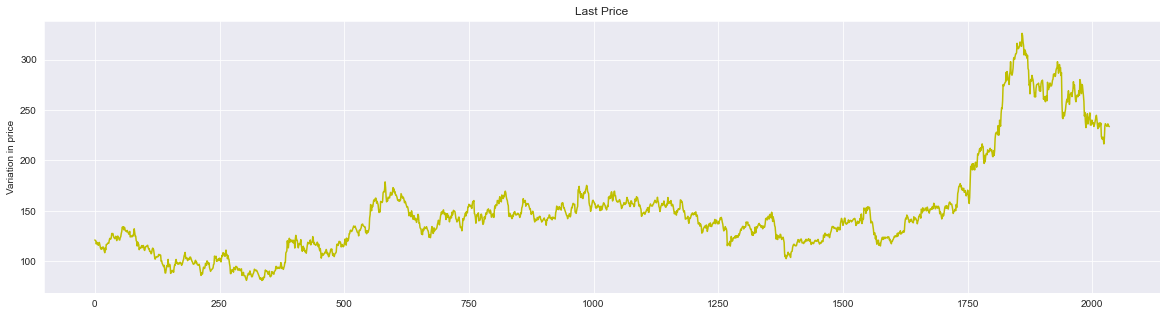

In [43]:
sns.set_style('darkgrid')
plt.figure(figsize = (20,5))
plt.plot(df.Last, color = 'y')
plt.ylabel('Variation in price')
plt.title("Last Price")
plt.show()

In [44]:
df.Date = pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index = df['Date']
df.drop('Date', axis = 1,inplace = True)
df

,index,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
Date,,,,,,,,
2010-07-21,2034,122.10,123.00,121.05,121.10,121.55,658666,803.56
2010-07-22,2033,120.30,122.00,120.25,120.75,120.90,293312,355.17
2010-07-23,2032,121.80,121.95,120.25,120.35,120.65,281312,340.31
2010-07-26,2031,120.10,121.00,117.10,117.10,117.60,658440,780.01
2010-07-27,2030,117.60,119.50,112.00,118.80,118.65,586100,694.98
...,...,...,...,...,...,...,...,...
2018-09-24,4,233.55,239.20,230.75,234.00,233.30,3423509,7999.55
2018-09-25,3,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
2018-09-26,2,240.00,240.00,232.50,235.00,234.25,2240909,5248.60


### Build the model

In [45]:
ds_high=df.reset_index()['High']

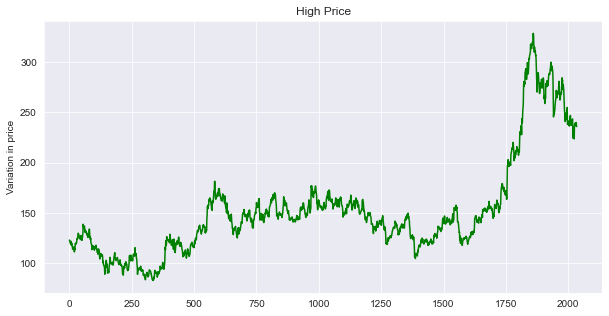

In [46]:
sns.set_style('darkgrid')
plt.figure(figsize = (10,5))
plt.plot(ds_high, color = 'g')
plt.ylabel('Variation in price')
plt.title("High Price")
plt.show()

## Feature Scaling Step

In [47]:
from sklearn.preprocessing import MinMaxScaler

In [48]:
from sklearn.preprocessing import MinMaxScaler

# Instantiate the scaler
scaler = MinMaxScaler()

# Fit and transform the data
df_close = scaler.fit_transform(np.array(df_close).reshape(-1, 1))

# Print the transformed data
print(df_close)


[[0.16584967]
 [0.16319444]
 [0.1621732 ]
 ...
 [0.62622549]
 [0.62214052]
 [0.62418301]]


The scaling and transformation have been successfully completed, as evident from the array representation above.

Next, it is necessary to proceed with data splitting.

In [49]:
df_close.shape

(2035, 1)

In [50]:
scaler = MinMaxScaler(feature_range = (0,1))
df_open = scaler.fit_transform(np.array(df_open).reshape(-1,1))
df_open.shape

(2035, 1)

In [51]:
print(df_open)

[[0.16626115]
 [0.15896188]
 [0.16504461]
 ...
 [0.64436334]
 [0.62226277]
 [0.6202352 ]]


In [52]:
training_size = int( len(df_open) * 0.75)
testing_size  = len(df_open) - training_size
train_data , test_data = df_open[0 : training_size, :], df_open[training_size : len(df_open), :1]
training_size , testing_size

(1526, 509)

In [53]:
train_data

array([[0.16626115],
       [0.15896188],
       [0.16504461],
       ...,
       [0.24594485],
       [0.24797242],
       [0.24776967]])

In [54]:
test_data

array([[0.23033252],
       [0.21938362],
       [0.22810219],
       [0.23215734],
       [0.23824006],
       [0.23763179],
       [0.23073804],
       [0.23540146],
       [0.23438767],
       [0.25283861],
       [0.24249797],
       [0.27169505],
       [0.27088402],
       [0.22648013],
       [0.24270073],
       [0.24898621],
       [0.24675588],
       [0.29541768],
       [0.28872668],
       [0.28710462],
       [0.28527981],
       [0.27534469],
       [0.29156529],
       [0.28325223],
       [0.28751014],
       [0.30352798],
       [0.28933496],
       [0.29115977],
       [0.27554745],
       [0.27128954],
       [0.23682076],
       [0.23073804],
       [0.24148418],
       [0.23641525],
       [0.23073804],
       [0.21492295],
       [0.20235199],
       [0.18896999],
       [0.19829684],
       [0.14963504],
       [0.17396594],
       [0.16991079],
       [0.15693431],
       [0.1703163 ],
       [0.16463909],
       [0.15328467],
       [0.15815085],
       [0.148

# Splitting the data into train and test sets

In [55]:
def create_dataset(dataset, time_step=1):
    train_X, train_Y = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        train_X.append(a)
        train_Y.append(dataset[i + time_step, 0])
    return np.array(train_X), np.array(train_Y)

In [56]:
time_step = 100
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

In [57]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [58]:
print("The shape of x_train is : ", x_train.shape), print("The shape of y_train is : ", y_train.shape)

The shape of x_train is :  (1425, 100, 1)
The shape of y_train is :  (1425,)


(None, None)

In [59]:
x_test.shape

(408, 100, 1)

In [60]:
y_test.shape

(408,)

In [61]:
# Reshaping the input to samples, time steps, features

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

### Create the LSTM Model  or Training the Model

In [62]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (100,1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [63]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 100, batch_size = 64, verbose = 1)

Epoch 1/100
23/23 [==============================] - 8s 314ms/step - loss: 6.1497e-04 - val_loss: 0.0057
Epoch 2/100
23/23 [==============================] - 7s 310ms/step - loss: 6.1465e-04 - val_loss: 0.0056
Epoch 3/100
23/23 [==============================] - 8s 330ms/step - loss: 6.0431e-04 - val_loss: 0.0048
Epoch 4/100
23/23 [==============================] - 7s 294ms/step - loss: 6.2584e-04 - val_loss: 0.0091
Epoch 5/100
23/23 [==============================] - 6s 273ms/step - loss: 6.0473e-04 - val_loss: 0.0042
Epoch 6/100
23/23 [==============================] - 6s 272ms/step - loss: 5.9754e-04 - val_loss: 0.0083
Epoch 7/100
23/23 [==============================] - 6s 278ms/step - loss: 5.3200e-04 - val_loss: 0.0088
Epoch 8/100
23/23 [==============================] - 6s 280ms/step - loss: 5.0349e-04 - val_loss: 0.0100
Epoch 9/100
23/23 [==============================] - 6s 275ms/step - loss: 5.0456e-04 - val_loss: 0.0066
Epoch 10/100
23/23 [==============================] - 7

23/23 [==============================] - 7s 285ms/step - loss: 1.4997e-04 - val_loss: 0.0016
Epoch 79/100
 5/23 [=====>........................] - ETA: 4s - loss: 1.5316e-04

## Make model predictions

In [65]:
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

In [66]:
train_predict

array([[0.14084712],
       [0.1393657 ],
       [0.13809589],
       ...,
       [0.23691826],
       [0.2372665 ],
       [0.23767278]], dtype=float32)

## Evaluation of the model

#### Calculate RMSE Performance Metrics

In [67]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

print('RMSE performance matrics : ',math.sqrt(mean_squared_error(y_train, train_predict)) )

RMSE performance matrics :  132.72685444804912


In [68]:
print("Test data RMSE : ",math.sqrt(mean_squared_error(y_test , test_predict)) )

Test data RMSE :  214.9514585774243


In [71]:
look_back = 100
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict

testPredictPlot = np.empty_like(df)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2)+1:len(df) - 1, :] = test_predict

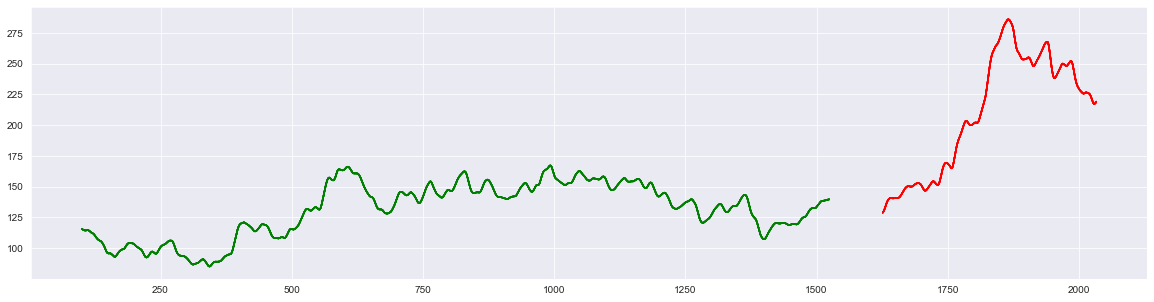

In [73]:
plt.subplots(figsize=(20,5))
plt.plot(trainPredictPlot,color='green')
plt.plot(testPredictPlot,color='red')
plt.show()

### Predictions for the next 30 days

In [74]:
x_ip = test_data[409:].reshape(1, -1)
x_ip.shape


(1, 100)

In the above code, test_data[409:] is a slice of the test_data array that includes the previous 100 days of data. The reshape function is then used to reshape this slice into a 2-dimensional array with 1 row and an undetermined number of columns.

After reshaping, you can access the shape of the x_ip array by calling x_ip.shape, which will output the tuple (1, num_columns), where num_columns is the number of columns in the reshaped array.

In [90]:
temp_ip = list(x_ip)
temp_ip = temp_ip[0].tolist()

In [77]:
lst_output=[]
n_steps=100

future_Days= 15

i=0

while(i<future_Days):
    
    if(len(temp_ip)>100):
        x_ip = np.array(temp_ip[1:])
        print("Day {} input {}".format(i,x_ip))
        
        x_ip = x_ip.reshape(1,-1)
        x_ip = x_ip.reshape((1, n_steps, 1))
        yhat = model.predict(x_ip, verbose=0)
        print("Day {} output {}\n".format(i,yhat))
        
        temp_ip.extend(yhat[0].tolist())
        temp_ip = temp_ip[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_ip = x_ip.reshape((1, n_steps,1))
        yhat = model.predict(x_ip, verbose=0)
        print(yhat[0])
        temp_ip.extend(yhat[0].tolist())
        print(len(temp_ip))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.5661276]
101
Day 1 input [0.84549878 0.85908354 0.824412   0.80656934 0.71107056 0.64436334
 0.65855637 0.67802109 0.66098946 0.66058394 0.67072182 0.68896999
 0.69383617 0.70397405 0.71492295 0.70113544 0.75385239 0.7648013
 0.74574209 0.70721817 0.736618   0.75344688 0.7404704  0.74817518
 0.736618   0.75385239 0.76520681 0.80312247 0.77230333 0.78487429
 0.7404704  0.7175588  0.71695053 0.72587186 0.74493106 0.74614761
 0.73763179 0.73641525 0.77007299 0.74371452 0.81062449 0.79622871
 0.76520681 0.75892133 0.78994323 0.78548256 0.7676399  0.74574209
 0.71695053 0.65064882 0.6784266  0.6431468  0.60888078 0.63990268
 0.66058394 0.67883212 0.62773723 0.64841849 0.6593674  0.65815085
 0.67964315 0.61394972 0.62814274 0.62469586 0.64841849 0.63321168
 0.63077859 0.63341444 0.61597729 0.62408759 0.6283455  0.64760746
 0.66058394 0.67234388 0.64557989 0.62206002 0.61111111 0.63219789
 0.61942417 0.62550689 0.63219789 0.62814274 0.63706407 0.57137064
 0.57948094 0.56731549 0.57339822 0

Day 9 output [[0.5462259]]

Day 10 input [0.66058394 0.67072182 0.68896999 0.69383617 0.70397405 0.71492295
 0.70113544 0.75385239 0.7648013  0.74574209 0.70721817 0.736618
 0.75344688 0.7404704  0.74817518 0.736618   0.75385239 0.76520681
 0.80312247 0.77230333 0.78487429 0.7404704  0.7175588  0.71695053
 0.72587186 0.74493106 0.74614761 0.73763179 0.73641525 0.77007299
 0.74371452 0.81062449 0.79622871 0.76520681 0.75892133 0.78994323
 0.78548256 0.7676399  0.74574209 0.71695053 0.65064882 0.6784266
 0.6431468  0.60888078 0.63990268 0.66058394 0.67883212 0.62773723
 0.64841849 0.6593674  0.65815085 0.67964315 0.61394972 0.62814274
 0.62469586 0.64841849 0.63321168 0.63077859 0.63341444 0.61597729
 0.62408759 0.6283455  0.64760746 0.66058394 0.67234388 0.64557989
 0.62206002 0.61111111 0.63219789 0.61942417 0.62550689 0.63219789
 0.62814274 0.63706407 0.57137064 0.57948094 0.56731549 0.57339822
 0.57339822 0.54845904 0.57725061 0.61658556 0.63584753 0.62793998
 0.62408759 0.61820762 0

In [83]:
day_new = np.arange(1,101)
day_pred = np.arange(101,116)

In [84]:
fd = df_open.tolist()
fd.extend(lst_output)

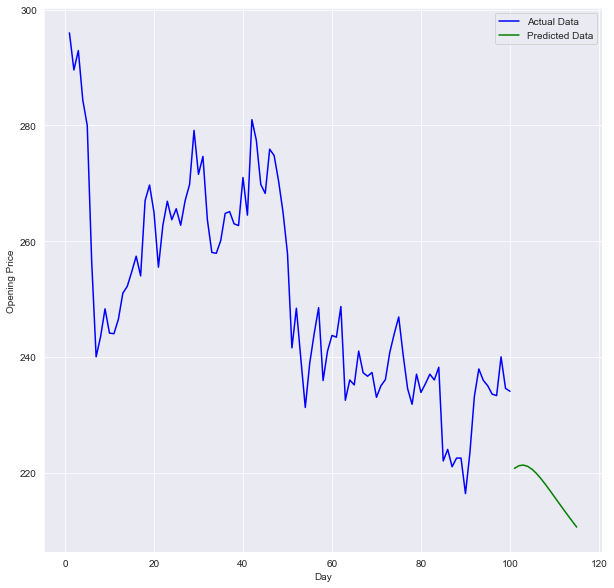

In [85]:
import matplotlib.pyplot as plt

# Set the figure size
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the actual data in blue
ax.plot(day_new, scaler.inverse_transform(df_open[1935:]), color='blue', label='Actual Data')

# Plot the predicted data in green
ax.plot(day_pred, scaler.inverse_transform(lst_output), color='green', label='Predicted Data')

# Add labels and legend
ax.set_xlabel('Day')
ax.set_ylabel('Opening Price')
ax.legend()

# Display the plot
plt.show()

## Result Plotting

In [114]:
trainPredictPlot = np.empty_like(ds_high)
trainPredictPlot[:] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back] = train_predict.reshape(-1)

testPredictPlot = np.empty_like(ds_high)
testPredictPlot[:] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2) + 1:len(ds_high) - 1] = test_predict.reshape(-1)


In [135]:
temp_input = list(X_input)
temp_input = temp_input[0].tolist()

In [136]:
day_new = np.arange(1,101)
day_pred = np.arange(101,131)

In [137]:
day_new.shape

(100,)

In [138]:
day_pred.shape

(30,)

In [139]:
data_new = ds_high.tolist()
data_new.extend(lst_output)

In [140]:
len(ds_high)

2035

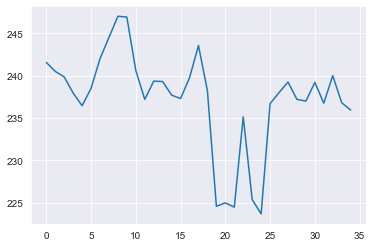

In [141]:

data_new = ds_high.tolist()
data_new.extend(lst_output)
plt.plot(data_new[2000:])

In [142]:
data_new = scaler.inverse_transform(df).tolist()

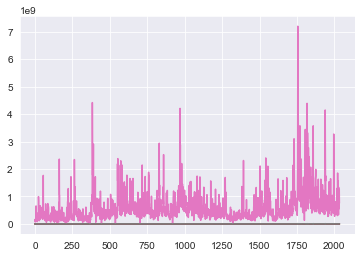

In [143]:
plt.plot(data_new)